버전 확인 및 라이브러리 설치

In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
!head /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 7
microcode	: 0xffffffff
cpu MHz		: 2200.216
cache size	: 39424 KB
physical id	: 0


In [1]:
!nvidia-smi

Fri Jul 14 11:40:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Install MMCV
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0rc1"
!pip install "mmdet>=3.0.0rc4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.7 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 31.0 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.7 MB/s eta 0:00:00


In [6]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 15727, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 15727 (delta 27), reused 65 (delta 18), pack-reused 15625
Receiving objects: 100% (15727/15727), 20.95 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (11037/11037), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [3]:
%cd mmsegmentation

/content/mmsegmentation


In [19]:
import os
import os.path as osp
import shutil

from tqdm.auto import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch, torchvision

import mmcv
import mmseg

In [ ]:
print(torch.__version__, torch.cuda.is_available())
print(mmseg.__version__)

2.0.1+cu118 True
1.1.0


데이터 압축해제 및 폴더 생성

In [8]:
!unzip -qq /content/drive/MyDrive/data.zip

In [5]:
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape)
    return img

# RLE 인코딩 함수
def rle_encode(mask):

    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [10]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class BuildingSegDataset(BaseSegDataset):
  METAINFO = dict(
      classes=("bg", "building"),
      palette=([128, 0, 0], [0, 128, 0])
  )
  def __init__(self,
               img_suffix=".png",
               seg_map_suffix=".png",
               **kwargs):
    super().__init__(
        img_suffix=img_suffix,
        seg_map_suffix=seg_map_suffix,
        **kwargs)


Creat Config File

In [11]:
from mmengine import Config
cfg = Config.fromfile('configs/mask2former/mask2former_swin-b-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024.py')
# print(f'Config:\n{cfg.pretty_text}')

In [12]:
# segnext
data_root = "data"
cfg.num_classes = 2

cfg.model.decode_head.num_classes = cfg.num_classes
cfg.model.decode_head.out_channels = 2
# cfg.model.decode_head.loss_cls.use_sigmoid = True

# cfg.model.decide_head.loss_decode =

# Modify dataset type and path
cfg.dataset_type = 'BuildingSegDataset'
cfg.data_root = data_root

# train : 7141 * 0.8 -> 5713
# 5713 / 8 -> 715 iter == 1 epoch

cfg.train_cfg.type = "IterBasedTrainLoop"
cfg.train_cfg.max_iters = 7150 * 3 # 30 epoch
cfg.train_cfg.val_interval = 715 * 3

cfg.default_hooks.logger.interval = 100
cfg.default_hooks.checkpoint.interval = 715 * 3

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(
        type='RandomChoiceResize',
        scales=[int(1024 * x * 0.1) for x in range(5, 21)],
        resize_type='ResizeShortestEdge',
        max_size=4096),
    dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs'),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(512, 512), keep_ratio=True),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(type='PackSegInputs'),
]


cfg.train_dataloader.num_workers = 3
cfg.train_dataloader.batch_size = 4
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.data_prefix = dict(img_path="images/train", seg_map_path="annotations/train")


cfg.val_dataloader.num_workers = 3
cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.data_prefix = dict(img_path="images/val", seg_map_path="annotations/val")

cfg.test_dataloader.num_workers = 3
cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.data_prefix = dict(img_path="images/val", seg_map_path="annotations/val")



cfg['randomness'] = dict(seed=42)
cfg.work_dir = './work_dirs/mask2former'

print(f'Config:\n{cfg.pretty_text}')

Config:
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'))
vis_backends = [
    dict(type='LocalVisBackend'),
]
visualizer = dict(
    type='SegLocalVisualizer',
    vis_backends=[
        dict(type='LocalVisBackend'),
    ],
    name='visualizer')
log_processor = dict(by_epoch=False)
log_level = 'INFO'
load_from = None
resume = False
tta_model = dict(type='SegTTAModel')
dataset_type = 'BuildingSegDataset'
data_root = 'data'
crop_size = (
    512,
    1024,
)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(
        type='RandomChoiceResize',
        scales=[
            512,
            614,
            716,
            819,
            921,
            1024,
            1126,
            1228,
            1331,
            1433,
            1536,
            1638,
            1740,
            1843,


In [13]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

07/14 11:42:13 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 42
    GPU 0: NVIDIA A100-SXM4-40GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compu

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


07/14 11:42:16 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/14 11:42:16 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

In [14]:
runner.train()

/content/mmsegmentation/mmseg/datasets/transforms/loading.py:83: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '


07/14 11:42:21 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:lr=1e-05
07/14 11:42:21 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:weight_decay=0.05
07/14 11:42:21 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:lr_mult=0.1
07/14 11:42:21 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:decay_mult=1.0
07/14 11:42:21 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:lr=1e-05
07/14 11:42:21 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:weight_decay=0.05
07/14 11:42:21 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:lr_mult=0.1
07/14 11:42:21 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:decay_mult=1.0
07/14 11:42:21 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:lr=1e-05
07/14 11:42:21 - mmengine - INFO - paramwi

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


07/14 11:44:07 - mmengine - INFO - Iter(train) [  100/21450]  base_lr: 9.9901e-05 lr: 9.9901e-06  eta: 6:01:06  time: 0.9750  data_time: 0.0153  memory: 33052  grad_norm: 303.5178  loss: 26.5053  decode.loss_cls: 0.0234  decode.loss_mask: 0.9680  decode.loss_dice: 1.4766  decode.d0.loss_cls: 2.0114  decode.d0.loss_mask: 0.8822  decode.d0.loss_dice: 1.5746  decode.d1.loss_cls: 0.0794  decode.d1.loss_mask: 0.9419  decode.d1.loss_dice: 1.4693  decode.d2.loss_cls: 0.0363  decode.d2.loss_mask: 0.9344  decode.d2.loss_dice: 1.4896  decode.d3.loss_cls: 0.0134  decode.d3.loss_mask: 0.9673  decode.d3.loss_dice: 1.4680  decode.d4.loss_cls: 0.0105  decode.d4.loss_mask: 0.9707  decode.d4.loss_dice: 1.4628  decode.d5.loss_cls: 0.0102  decode.d5.loss_mask: 0.9656  decode.d5.loss_dice: 1.4498  decode.d6.loss_cls: 0.0113  decode.d6.loss_mask: 0.9729  decode.d6.loss_dice: 1.4487  decode.d7.loss_cls: 0.0123  decode.d7.loss_mask: 0.9687  decode.d7.loss_dice: 1.4640  decode.d8.loss_cls: 0.0159  decode.d8.l

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0-1): 2 x SwinBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
 

inference

In [15]:
!unzip -qq /content/drive/MyDrive/test_img.zip -d data/

Loads checkpoint by local backend from path: ./work_dirs/mask2former/best_mIoU_iter_21450.pth
07/14 17:55:32 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


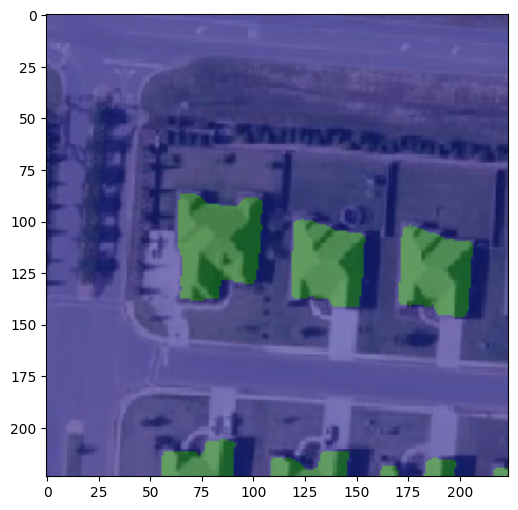

In [16]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/mask2former/best_mIoU_iter_21450.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('./data/test_img/TEST_00000.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

In [18]:
submit = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")

In [24]:
mask_lst = []
for idx, row in tqdm(submit.iterrows(), total=len(submit["img_id"])):
  img = mmcv.imread(f"./data/test_img/{row['img_id']}.png")
  result = inference_model(model, img)
  mask = result.pred_sem_seg.data
  mask = mask.detach().cpu().numpy()
  mask = rle_encode(mask)
  if mask == '':
    mask = -1
  mask_lst.append(mask)
submit["mask_rle"] = mask_lst
submit.to_csv("answer.csv", index=False)

  0%|          | 0/60640 [00:00<?, ?it/s]